# Audio Classification: Speaker & Language

This notebook does the following:
1. Use a single **metadata CSV** to label both **speaker** and **language**.
2. Extract **MFCC features** from each audio file.
3. Perform **binary classification** separately for:
   - **Speaker** (Jeevan vs. Not_Jeevan)
   - **Language** (English vs. Not_English)
4. Use **k-Fold Cross-Validation** to evaluate performance (accuracy, precision, recall, F1) and generate confusion matrices.

In [2]:
#Importing ALl libraries
import os
import pandas as pd
import librosa
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Data Collection
__ Add Text Here

* Youtube
* Google Photos
* Facebook and Messenger
* Recorded to balance Data

# Data Pre Processing
__ Add text here

And code if needed. Or link to Github
* Used yt_dlp to download just the audio from youtube videos (These videos contain just my speech). No copyright infriengement intended. The channel used is in the codecell.
* Used __ to convert all video into audio
* Used librosa, ffemg to trim audio data into equal slices of 7 seconds (source for why that's suitable), removed silence, and added empty voice when a segment would be less than 7 seconds.

## What needs to be done:
These factors might result in some inaccuracy.
* The audio is recorded from a phone, often with a lot of wind or people in the background. So, there's some noise that needs to be cleaned.
* Some data is labeled as one class but has data from both classes. 
    * In conversations when both people are speaking in one segment, I classified it based on whoever is speaking for a longer time duration. 
    * People who speak Nepali also sprinkle English words in between, again I used the majority time rule to label data.

# Data Labeling
The most challenging part after fining the data was labeling.

__ Add more__

# Data Analysis

## Initial Distribution: 
Total Files: 561

Counts by Speaker:
  speaker_label  count
0        Jeevan    418
1    Not_Jeevan    143

Counts by Language:
  language_label  count
0    Not_English    350
1        English    211
Add image of initial distribution here and then show the new one.

Total Files: 823

Counts by Speaker:
  speaker_label  count
0        Jeevan    418
1    Not_Jeevan    405

Counts by Language:
  language_label  count
0    Not_English    434
1        English    389


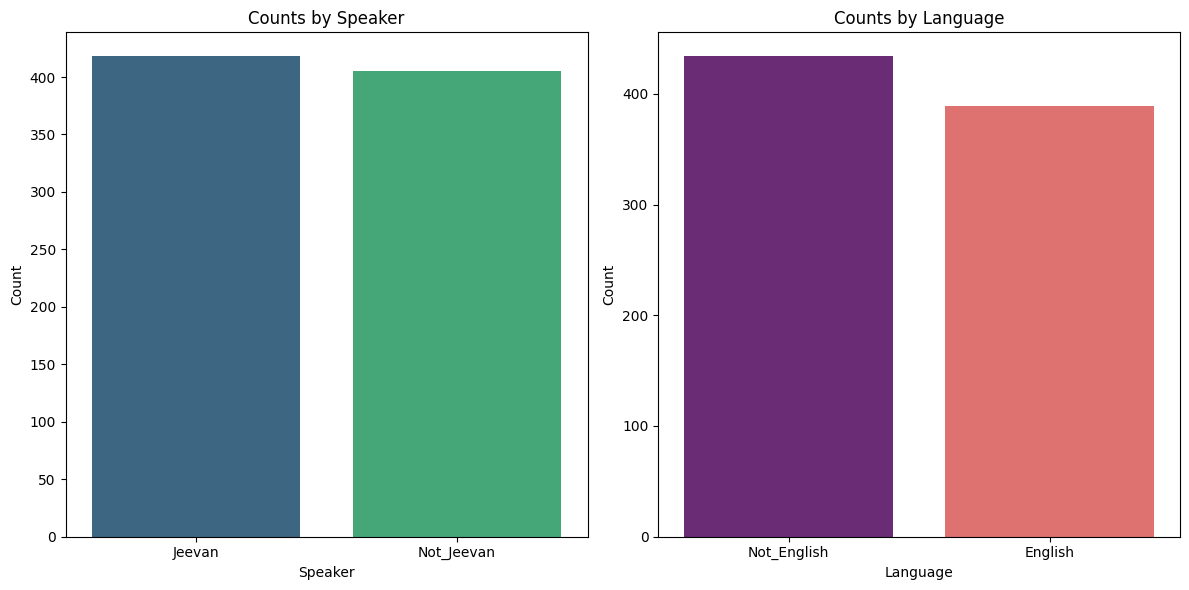

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress FutureWarnings from seaborn (or other libraries)
warnings.filterwarnings("ignore", category=FutureWarning)

# Load the CSV file, which already has a header row
df = pd.read_csv('data/metadata.csv') 

# Total data statistics
total_files = len(df)
print("Total Files:", total_files)

# Statistics by speaker
speaker_counts = df['speaker_label'].value_counts().reset_index()
speaker_counts.columns = ['speaker_label', 'count']
print("\nCounts by Speaker:")
print(speaker_counts)

# Statistics by language
language_counts = df['language_label'].value_counts().reset_index()
language_counts.columns = ['language_label', 'count']
print("\nCounts by Language:")
print(language_counts)

# Visualization: Bar plots for speaker and language counts
plt.figure(figsize=(12, 6))

# Bar plot for speaker counts
plt.subplot(1, 2, 1)
sns.barplot(data=speaker_counts, x='speaker_label', y='count', palette="viridis")
plt.title("Counts by Speaker")
plt.xlabel("Speaker")
plt.ylabel("Count")

# Bar plot for language counts
plt.subplot(1, 2, 2)
sns.barplot(data=language_counts, x='language_label', y='count', palette="magma")
plt.title("Counts by Language")
plt.xlabel("Language")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


In [11]:

def extract_features(file_path, sr=16000, n_mfcc=13):
    """
    Loads the audio file, extracts MFCC features, and returns the averaged MFCCs.
    """
    y, sr = librosa.load(file_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)
    return mfcc_mean

def build_dataset(metadata_csv, audio_dir):
    """
    Reads metadata from a CSV that has at least 3 columns:
        - filename
        - speaker_label (e.g., "Jeevan" or "Not_Jeevan")
        - language_label (e.g., "English" or "Not_English")
    """
    df = pd.read_csv(metadata_csv)
    X, y_speaker, y_language = [], [], []
    for _, row in df.iterrows():
        file_path = os.path.join(audio_dir, row['filename'])
        X.append(extract_features(file_path))
        y_speaker.append(1 if row['speaker_label'].lower() == 'jeevan' else 0)
        y_language.append(1 if row['language_label'].lower() == 'english' else 0)
    return np.array(X), np.array(y_speaker), np.array(y_language)

def evaluate_classifier(X, y, n_splits=5):
    """
    Performs k-Fold cross-validation, returns classification metrics and a confusion matrix.
    """
    clf = SVC(kernel='linear', probability=True, random_state=42)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    y_pred = cross_val_predict(clf, X, y, cv=skf)
    return classification_report(y, y_pred, target_names=["Class 0", "Class 1"]), confusion_matrix(y, y_pred)

# Models Used Use K-fold cross validation

In [19]:
def extract_features(file_path, sr=16000, n_mfcc=13):
    """
    Loads the audio file, extracts MFCC features, and returns the averaged MFCCs.
    """
    y, sr = librosa.load(file_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)
    return mfcc_mean

def build_dataset(metadata_csv, audio_dir):
    """
    Reads metadata from a CSV that has at least 3 columns:
        - filename
        - speaker_label (e.g., "Jeevan" or "Not_Jeevan")
        - language_label (e.g., "English" or "Not_English")
    
    For each row:
      - Extracts MFCC features from the audio file.
      - Creates a binary label for speaker (1 for "Jeevan", 0 for others).
      - Creates a binary label for language (1 for "English", 0 for others).
    
    Returns:
      - X: Array of MFCC feature vectors.
      - y_speaker: Array of binary labels for speaker classification.
      - y_language: Array of binary labels for language classification.
    """
    df = pd.read_csv(metadata_csv)
    X, y_speaker, y_language = [], [], []
    for _, row in df.iterrows():
        file_path = os.path.join(audio_dir, row['filename'])
        features = extract_features(file_path)
        X.append(features)
        y_speaker.append(1 if row['speaker_label'].lower() == 'jeevan' else 0)
        y_language.append(1 if row['language_label'].lower() == 'english' else 0)
    return np.array(X), np.array(y_speaker), np.array(y_language)

def evaluate_classifier(X, y, clf, n_splits=5):
    """
    Performs k-Fold cross-validation using the specified classifier.
    
    Parameters:
      - X: Feature array.
      - y: True labels.
      - clf: A classifier instance.
      - n_splits: Number of folds for cross-validation.
    
    Returns:
      - report: A classification report as a string.
      - cm: The confusion matrix as a NumPy array.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    y_pred = cross_val_predict(clf, X, y, cv=skf)
    report = classification_report(y, y_pred, target_names=["Class 0", "Class 1"])
    cm = confusion_matrix(y, y_pred)
    return report, cm

def run_multiple_classifiers(X, y, classifiers, n_splits=5):
    """
    Evaluates multiple classifiers using K-fold cross-validation.
    
    Parameters:
      - X: Features array.
      - y: Labels.
      - classifiers: Dictionary of classifiers (name: classifier instance).
      - n_splits: Number of cross-validation folds.
    
    Returns:
      - A dictionary mapping classifier names to their evaluation results (report and confusion matrix).
    """
    results = {}
    for name, clf in classifiers.items():
        print(f"Evaluating {name}...")
        report, cm = evaluate_classifier(X, y, clf, n_splits)
        results[name] = {"report": report, "confusion_matrix": cm}
    return results
def plot_confusion_matrix(cm, title):
    """
    Plots the confusion matrix using seaborn heatmap.
    """
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


In [23]:
# Evaluate classifiers for Speaker Classification

# Paths to metadata CSV and audio files folder
metadata_csv_path = "data/metadata.csv"
audio_directory = "data/audio_data"

# Build dataset
X, y_speaker, y_language = build_dataset(metadata_csv_path, audio_directory)
# Cell 2: Build Dataset and Evaluate Classifiers

# Define multiple classifiers.
# Note: Increased max_iter for LogisticRegression to reduce convergence warnings.
classifiers = {
    "SVM": SVC(kernel='linear', probability=True, random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42)
}


print("### Speaker Classification Results ###")
speaker_results = run_multiple_classifiers(X, y_speaker, classifiers)

# Evaluate classifiers for Language Classification
print("\n### Language Classification Results ###")
language_results = run_multiple_classifiers(X, y_language, classifiers)


### Speaker Classification Results ###
Evaluating SVM...
Evaluating RandomForest...
Evaluating LogisticRegression...

### Language Classification Results ###
Evaluating SVM...
Evaluating RandomForest...
Evaluating LogisticRegression...


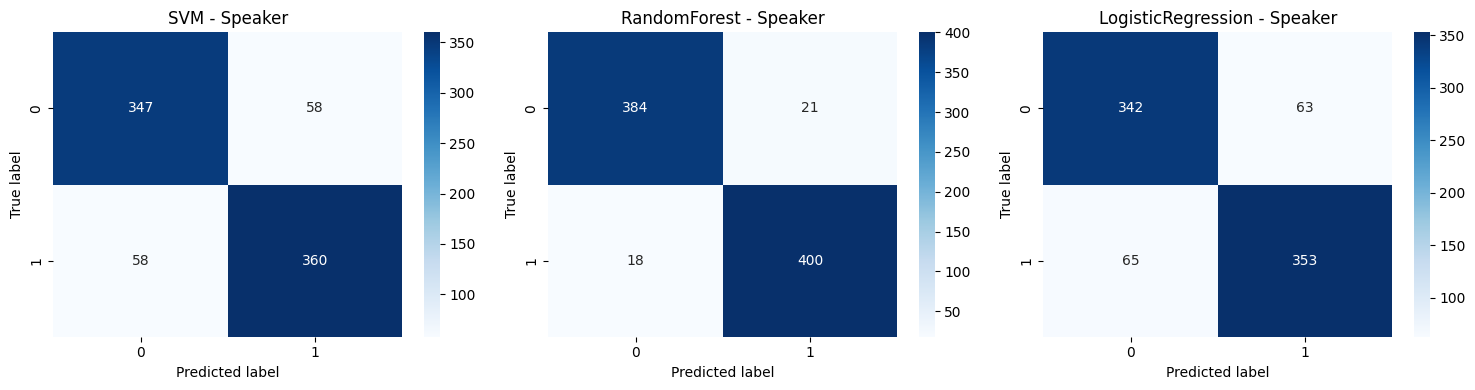

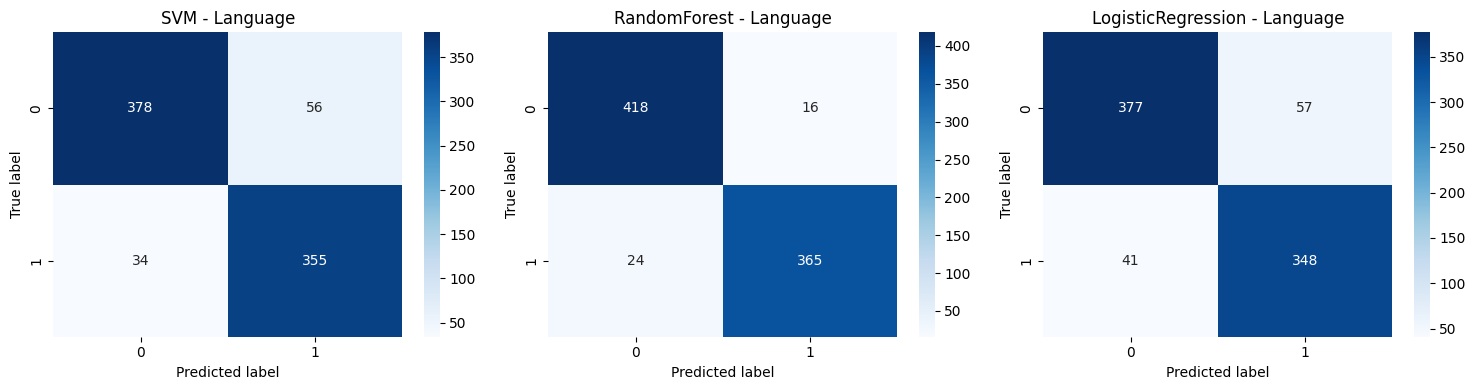

### Detailed Classification Reports for Speaker Classification ###

Classifier: SVM
              precision    recall  f1-score   support

     Class 0       0.86      0.86      0.86       405
     Class 1       0.86      0.86      0.86       418

    accuracy                           0.86       823
   macro avg       0.86      0.86      0.86       823
weighted avg       0.86      0.86      0.86       823

Confusion Matrix:
[[347  58]
 [ 58 360]]

Classifier: RandomForest
              precision    recall  f1-score   support

     Class 0       0.96      0.95      0.95       405
     Class 1       0.95      0.96      0.95       418

    accuracy                           0.95       823
   macro avg       0.95      0.95      0.95       823
weighted avg       0.95      0.95      0.95       823

Confusion Matrix:
[[384  21]
 [ 18 400]]

Classifier: LogisticRegression
              precision    recall  f1-score   support

     Class 0       0.84      0.84      0.84       405
     Class 1 

In [25]:
# Result Visualizations

def visualize_results(results, label_type):
    """
    Plots confusion matrices for each classifier.
    """
    num_classifiers = len(results)
    fig, axes = plt.subplots(1, num_classifiers, figsize=(5 * num_classifiers, 4))
    if num_classifiers == 1:
        axes = [axes]
    for ax, (name, res) in zip(axes, results.items()):
        cm = res['confusion_matrix']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_title(f"{name} - {label_type}")
        ax.set_ylabel('True label')
        ax.set_xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Visualize confusion matrices for Speaker Classification
visualize_results(speaker_results, 'Speaker')

# Visualize confusion matrices for Language Classification
visualize_results(language_results, 'Language')

# Optionally, print the detailed classification reports
print("### Detailed Classification Reports for Speaker Classification ###")
for name, res in speaker_results.items():
    print(f"\nClassifier: {name}")
    print(res["report"])
    print("Confusion Matrix:")
    print(res["confusion_matrix"])
    
print("\n### Detailed Classification Reports for Language Classification ###")
for name, res in language_results.items():
    print(f"\nClassifier: {name}")
    print(res["report"])
    print("Confusion Matrix:")
    print(res["confusion_matrix"])


# Mathematical Explanation 

## 1. Feature Extraction: MFCC Averaging

For each audio file, we extract Mel Frequency Cepstral Coefficients (MFCCs) which provide a compact representation of the audio's spectral properties.

- **MFCC Extraction:**  
  The audio signal is first transformed into the frequency domain using a Short-Time Fourier Transform (STFT). The resulting spectrogram is mapped to the Mel scale (a perceptually motivated frequency scale), and then a Discrete Cosine Transform (DCT) is applied to decorrelate the coefficients.

- **Averaging MFCCs:**  
  Let \( \text{MFCC}(i, t) \) be the \( i \)-th MFCC coefficient at time frame \( t \). The function computes the mean value of each coefficient across all \( T \) time frames:

  $$ 
  \text{MFCC}_\text{mean}(i) = \frac{1}{T} \sum_{t=1}^{T} \text{MFCC}(i, t)
  $$

  This averaged vector serves as a fixed-length feature representation of the audio file.

## 2. Dataset Construction and Labeling

The dataset is built by reading a metadata CSV file containing at least the columns: `filename`, `speaker_label`, and `language_label`. For each audio file:

- **Feature Vector (\( X \))**:  
  The averaged MFCC vector obtained from the audio file.

- **Binary Labels:**  
  Two binary labels are created:
  - **Speaker Label (\( y_{\text{speaker}} \))**:

    $$
    y_{\text{speaker}} = 
    \begin{cases}
    1, & \text{if the speaker is "Jeevan"} \\
    0, & \text{otherwise}
    \end{cases}
    $$

  - **Language Label (\( y_{\text{language}} \))**:

    $$
    y_{\text{language}} = 
    \begin{cases}
    1, & \text{if the language is "English"} \\
    0, & \text{otherwise}
    \end{cases}
    $$

## 3. K-Fold Cross Validation

K-Fold Cross Validation is used to assess the generalization performance of a model. The procedure is as follows:

- **Data Splitting:**  
  The dataset is split into \( K \) folds (e.g., 5). For each fold \( i \) (where \( i = 1, \dots, K \)):

  - **Train** the model on \( K-1 \) folds.
  - **Test** the model on the remaining fold.

- **Performance Metrics:**  
  Let \( a_i \) be the performance (e.g., accuracy) on the \( i \)-th fold. The overall performance is computed as:

  $$
  \text{Average Accuracy} = \frac{1}{K} \sum_{i=1}^{K} a_i
  $$

  and the standard deviation is:

  $$
  \sigma = \sqrt{\frac{1}{K} \sum_{i=1}^{K} \left(a_i - \text{Average Accuracy}\right)^2}
  $$

  This approach provides a robust performance estimate by averaging over multiple train-test splits.

## 4. Classification Models

In the extended code, we evaluate multiple classifiers using K-Fold Cross Validation. Here are the mathematical (and conceptual) foundations of these classifiers:

---

### 4.1 Support Vector Machine (SVM)

**Goal:** Find a hyperplane that maximizes the margin between two classes.  

1. **Linear SVM Decision Boundary:**

   $$
   w \cdot x + b = 0
   $$

   where \( w \) is the weight vector and \( b \) is a bias term.

2. **Hard-Margin Optimization (Linearly Separable Data):**  
   The SVM solves

   $$
   \min_{w, b} \;\; \frac{1}{2} \|w\|^2
   $$

   subject to

   $$
   y_i(w \cdot x_i + b) \ge 1 \quad \forall i,
   $$

   where \( y_i \in \{-1, +1\} \) are the class labels and \( x_i \) are feature vectors.

3. **Soft-Margin SVM (Realistic Case):**  
   Introduces slack variables \( \xi_i \) to allow some misclassifications:

   $$
   \min_{w, b, \xi} \;\; \frac{1}{2}\|w\|^2 + C \sum_{i=1}^N \xi_i
   $$

   subject to

   $$
   y_i(w \cdot x_i + b) \ge 1 - \xi_i, \quad \xi_i \ge 0.
   $$

---

### 4.2 Random Forest

**Goal:** Create an ensemble of diverse decision trees to reduce overfitting and improve predictive performance.

1. **Bootstrap Sampling:**  
   Each tree is trained on a **bootstrap sample** of the training data (sampling with replacement).

2. **Random Feature Subset:**  
   At each split in a tree, only a random subset of features is considered.

3. **Prediction Aggregation:**  
   The final prediction is made by majority vote across all trees:

   $$
   \hat{y} = \text{majority\_vote} \Bigl\{ T_1(x), T_2(x), \dots, T_m(x) \Bigr\},
   $$

   where \( T_j \) is the \( j \)-th decision tree, and \( m \) is the number of trees in the forest.

---

### 4.3 Logistic Regression

**Goal:** Model the probability that a given instance belongs to a certain class.

1. **Model Formulation:**  
   Logistic Regression assumes:

   $$
   \hat{y} = \sigma\bigl(w_0 + w_1 x_1 + \dots + w_n x_n\bigr)
   $$

   where the **sigmoid function** \( \sigma(z) \) is:

   $$
   \sigma(z) = \frac{1}{1 + e^{-z}}.
   $$

2. **Training Objective (Cross-Entropy Loss):**  
   We seek parameter values that minimize the log loss:

   $$
   \text{LogLoss} = -\sum_{i=1}^{N} \Bigl[y_i \log(\hat{y}_i) + (1 - y_i) \log\bigl(1 - \hat{y}_i\bigr)\Bigr],
   $$

   where \( y_i \in \{0,1\} \) is the true label and \( \hat{y}_i \) is the predicted probability.

---

## Summary

1. **MFCC Extraction:** Converts each audio file into a fixed-length feature vector by averaging MFCCs over time.  
2. **Dataset Construction:** Combines the MFCC feature vectors with binary labels (speaker, language) drawn from CSV metadata.  
3. **K-Fold Cross Validation:** Provides a robust estimate of model performance by averaging results across multiple train/test splits.  
4. **Classification Models:**
   - **SVM:** Finds a hyperplane (or decision boundary) that maximizes the margin.  
   - **Random Forest:** Constructs many decision trees from bootstrap samples and aggregates their predictions (majority vote).  
   - **Logistic Regression:** Models class probability via the sigmoid function and optimizes parameters by minimizing cross-entropy loss.


# Comparison of All models